In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [3]:
# To enable the autocomplete
%config Completer.use_jedi = False

# Global Definitions

In [4]:
# The input of CNN (square image)
IMAGE_SIZE = 128
BATCH_SIZE = 32

# Prepating the dataset

## Loading the dataset

**Categories**
- Cat == 0
- Dog == 1

In [5]:
# unzip the dataset

# Just needed do once
# !mkdir "/kaggle/tmp"
# !unzip "/kaggle/input/dogs-vs-cats/test1.zip" -d "/kaggle/tmp/"
# !unzip "/kaggle/input/dogs-vs-cats/train.zip" -d "/kaggle/tmp/"

In [6]:
test_images_dir = "/kaggle/tmp/test1/"
train_images_dir= "/kaggle/tmp/train/"
sample_sub_path = "/kaggle/input/dogs-vs-cats/sampleSubmission.csv"

In [7]:
# !ls "/kaggle/tmp/train/"dog.*

In [8]:
# Submission example
submit_example = pd.read_csv(sample_sub_path)
submit_example.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
list_images_path = os.listdir(train_images_dir)

labels = []
for image_path in list_images_path:
    if "cat" in image_path:
        labels.append('cat')
    else:
        labels.append('dog')

df = pd.DataFrame({"file":list_images_path, "label":labels})

print(df.head())
print(df.tail())

           file label
0   dog.890.jpg   dog
1  dog.1178.jpg   dog
2  dog.7845.jpg   dog
3  dog.4632.jpg   dog
4  cat.3660.jpg   cat
               file label
24995  dog.6505.jpg   dog
24996  cat.3805.jpg   cat
24997  cat.5513.jpg   cat
24998  cat.6808.jpg   cat
24999  dog.7780.jpg   dog


<AxesSubplot:>

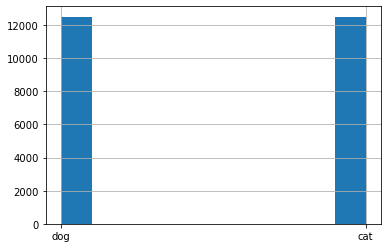

In [10]:
df['label'].hist()

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

(-0.5, 499.5, 368.5, -0.5)

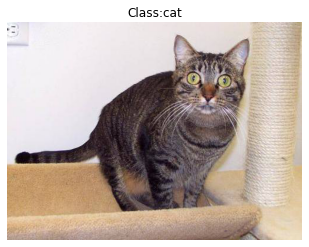

In [12]:
sample = np.random.randint(len(df))

img_path = train_images_dir + df['file'][sample]
label    = df['label'][sample]

img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Class:{label}")
plt.axis('off')

In [13]:
df.shape

(25000, 2)

## Spliting the dataset

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_df, valid_df = train_test_split(df, test_size = 0.15)

In [16]:
print("Train set:", train_df.shape)
print("Validation set:", valid_df.shape)

Train set: (21250, 2)
Validation set: (3750, 2)


In [17]:
train_df.head()

,file,label
22991,cat.6799.jpg,cat
7839,cat.11920.jpg,cat
2825,dog.12451.jpg,dog
5995,dog.8366.jpg,dog
7718,cat.12179.jpg,cat


## Data augmentation

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_gen = ImageDataGenerator(rescale = 1.0/255.0,
                               horizontal_flip = True,
                               vertical_flip   = True,
                               fill_mode = 'nearest',
                               rotation_range = 10,
                               width_shift_range = 0.2,
                               height_shift_range= 0.2,
                               shear_range= 0.15,
                               brightness_range= (.5,1.2),
                               zoom_range = 0.2)

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
train_gen = train_gen.flow_from_dataframe(train_df,
                                          directory = train_images_dir,
                                          x_col = 'file', 
                                          y_col = 'label', 
                                          target_size =(IMAGE_SIZE, IMAGE_SIZE), 
                                          class_mode = 'categorical',
                                          batch_size = BATCH_SIZE, 
                                          color_mode = 'rgb', 
                                          shuffle = True)

Found 21250 validated image filenames belonging to 2 classes.


**Let's take a look at some generates images**

(32, 128, 128, 3)


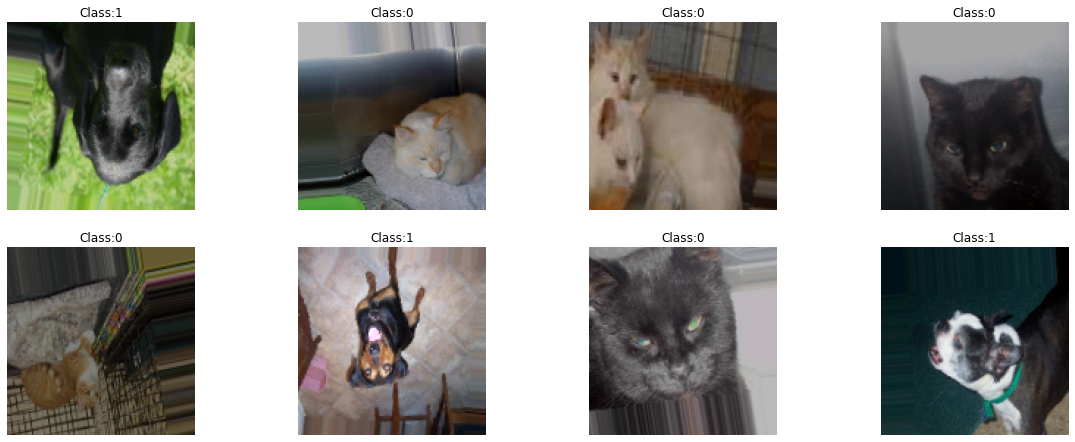

In [20]:
n_samples = 8

plt.figure(figsize=(20,20))
for x_gens, y_gens in train_gen:
#     the first dimension of x_gens and y_gens will be equal to batch_size specifed previously
    print(x_gens.shape)
    i = 0
    for sample_img, sample_class in zip(x_gens, y_gens):
        
        plt.subplot(5,4,i+1)
        plt.title(f'Class:{np.argmax(sample_class)}')
        plt.axis('off')
        plt.imshow(sample_img)
        
        i += 1
        
        if i >= n_samples:
            break
    break

In [21]:
valid_gen = ImageDataGenerator(rescale=1./255)
valid_gen = valid_gen.flow_from_dataframe( valid_df, 
                                           directory = train_images_dir,
                                           x_col='file',
                                           y_col='label',
                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE)

Found 3750 validated image filenames belonging to 2 classes.


# The Model

In [22]:
from tensorflow import keras

In [23]:
def myModel(input_shape):
    
    X_input = keras.layers.Input(shape=input_shape, name='input')
    
#     128x128x3
    
    X = keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', name='conv-1')(X_input)    
    X = keras.layers.BatchNormalization(name='b1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
    
#     64x64x32
    
    X = keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', name='conv-2')(X)    
    X = keras.layers.BatchNormalization(name='b2')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
#     32x32x64

    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-3')(X)    
    X = keras.layers.BatchNormalization(name='b3')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)

#     16x16x128
    
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-4')(X)    
    X = keras.layers.BatchNormalization(name='b4')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)

#     8x8x128
    
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', name='conv-5')(X)    
    X = keras.layers.BatchNormalization(name='b5')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPool2D(pool_size=(2,2))(X)
    X = keras.layers.Dropout(0.2)(X)
    
#     8x8x128
    
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(units=512, name='fc-6')(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.Dropout(0.3)(X)
    
    X = keras.layers.Dense(units=2, activation='softmax', name='output')(X)
    
    model = keras.Model(inputs = X_input, outputs = X, name='My_CNN_Model')
    
    return model
    

In [24]:
model = myModel((IMAGE_SIZE,IMAGE_SIZE,3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "My_CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv-1 (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
b1 (BatchNormalization)      (None, 128, 128, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv-2 (Conv2D)              (None, 64, 64, 64)       

# Training

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
# To stop the training after N epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=2)
# To reduce the learning rate when the accuracy not increase for 5 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [27]:
# callbacks = [earlystop, learning_rate_reduction]
callbacks = [earlystop]

In [28]:
# model.load_weights("./weights.h5")
epochs = 30
history = model.fit(train_gen, 
                    steps_per_epoch = len(train_df)//BATCH_SIZE, 
                    epochs = epochs, 
                    validation_data = valid_gen, 
                    validation_steps = len(valid_df)//BATCH_SIZE)

Epoch 1/30
664/664 [==============================] - 149s 218ms/step - loss: 0.7949 - accuracy: 0.5663 - val_loss: 0.5982 - val_accuracy: 0.6765
Epoch 2/30
664/664 [==============================] - 143s 216ms/step - loss: 0.6339 - accuracy: 0.6418 - val_loss: 0.6110 - val_accuracy: 0.6680
Epoch 3/30
664/664 [==============================] - 144s 216ms/step - loss: 0.5818 - accuracy: 0.6889 - val_loss: 0.7812 - val_accuracy: 0.6368
Epoch 4/30
664/664 [==============================] - 144s 217ms/step - loss: 0.5401 - accuracy: 0.7274 - val_loss: 0.5127 - val_accuracy: 0.7374
Epoch 5/30
664/664 [==============================] - 144s 217ms/step - loss: 0.5071 - accuracy: 0.7567 - val_loss: 0.5113 - val_accuracy: 0.7615
Epoch 6/30
664/664 [==============================] - 143s 216ms/step - loss: 0.4923 - accuracy: 0.7669 - val_loss: 0.3951 - val_accuracy: 0.8213
Epoch 7/30
664/664 [==============================] - 144s 216ms/step - loss: 0.4699 - accuracy: 0.7740 - val_loss: 0.4271 -

In [29]:
# Saving the weights
model.save_weights('/kaggle/working/weights_v3.h5')

# Evaluating

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
print("Accuracy = ", history.history['accuracy'][-1])
print("Val. Accuracy = ", history.history['val_accuracy'][-1])

Accuracy =  0.893439531326294
Val. Accuracy =  0.9118589758872986


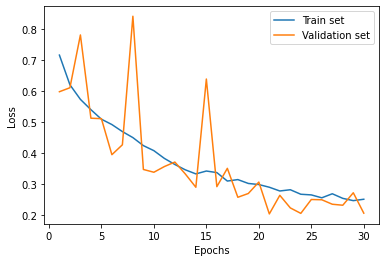

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

plt.plot(epochs, loss, label='Train set')
plt.plot(epochs, val_loss, label='Validation set')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

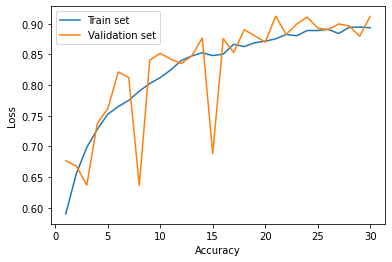

In [33]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1,len(loss)+1)

plt.plot(epochs, accuracy, label='Train set')
plt.plot(epochs, val_accuracy, label='Validation set')

plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.show()

**If I'd let training more it will be better**

# Prediction from test subset

In [34]:
test_images_path = os.listdir(test_images_dir)
test_df = pd.DataFrame({'file':test_images_path})
test_df.head()

,file
0,10435.jpg
1,6790.jpg
2,4644.jpg
3,1835.jpg
4,1102.jpg


In [35]:
test_gen = ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_gen.flow_from_dataframe(test_df, 
                                        directory=test_images_dir, 
                                        x_col='file', 
                                        y_col=None,
                                        class_mode=None,
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        color_mode="rgb",
                                        shuffle = False)

Found 12500 validated image filenames.


In [36]:
predictions = model.predict(test_gen)

In [37]:
predictions = np.argmax(predictions,axis=1)
predictions.shape

(12500,)

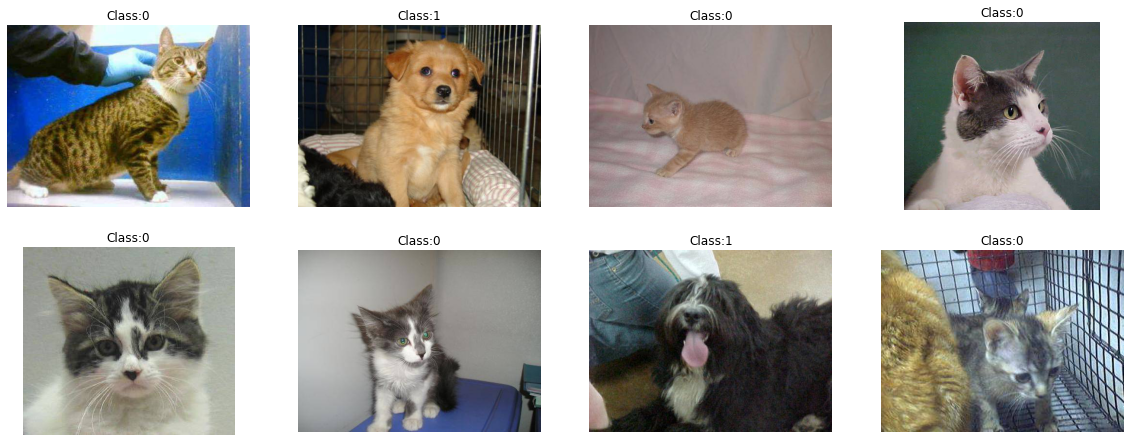

In [38]:
nsamples = 8

plt.figure(figsize=(20,20))
for i, file in enumerate(test_df['file'][:nsamples]):
    img = Image.open(test_images_dir+file)
    
    plt.subplot(5,4, i+1)
    plt.imshow(img)
    plt.title(f"Class:{predictions[i]}")
    plt.axis('off')

# Submission

In [39]:
submit_df = pd.DataFrame()
submit_df['id'] = range(1,len(predictions)+1)
submit_df['label'] = predictions

submit_df.to_csv('./submission.csv', index=False)

submit_df.head(10)

,id,label
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
5,6,0
6,7,1
7,8,0
8,9,0
9,10,0
